# Solar Panel Power Prediction & Dust Detection Pipeline

## Project Overview
This notebook demonstrates the complete Machine Learning Pipeline for determining solar panel performance. The goal is to predict the **expected (ideal) power output** based on weather conditions. By comparing this prediction with the actual output, we can identify performance degradation caused by dust accumulation.

### Pipeline Steps:
1.  **Data Loading**: Reading Generation and Weather datasets.
2.  **Data Preprocessing**: Merging, cleaning, and handling timestamps.
3.  **Feature Engineering**: Creating useful features like `HOUR` and `MONTH`.
4.  **Model Selection**: Training and comparing **Linear Regression**, **Random Forest**, and **XGBoost**.
5.  **Evaluation**: Selecting the best model based on R2 Score and RMSE.
6.  **Saving**: Exporting the model for the Web Application.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# Settings
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

## 1. Data Loading
We use the **Plant 1** datasets: Generation Data (Inverter level) and Weather Data (Plant level).

In [2]:
# Load Datasets
gen_df = pd.read_csv('datasets/Plant_1_Generation_Data.csv')
weather_df = pd.read_csv('datasets/Plant_1_Weather_Sensor_Data.csv')

print("Generation Data Shape:", gen_df.shape)
print("Weather Data Shape:", weather_df.shape)

Generation Data Shape: (68778, 7)
Weather Data Shape: (3182, 6)


## 2. Data Preprocessing
- **Standardize Time**: Convert `DATE_TIME` to datetime objects.
- **Merge**: Join datasets on `DATE_TIME` to associate weather with power generation.

In [3]:
# Convert to datetime
gen_df['DATE_TIME'] = pd.to_datetime(gen_df['DATE_TIME'])
weather_df['DATE_TIME'] = pd.to_datetime(weather_df['DATE_TIME'])

# Merge Data (Left join to keep all generation records)
merged_df = pd.merge(gen_df, weather_df, on=["DATE_TIME", "PLANT_ID"], how="left")

# Drop rows with missing weather data (if any)
merged_df = merged_df.dropna(subset=['IRRADIATION', 'MODULE_TEMPERATURE'])

print("Merged Data Shape:", merged_df.shape)
merged_df.head()

Merged Data Shape: (68774, 11)


C:\Users\Eng-Azhar\AppData\Local\Temp\ipykernel_16012\1697103798.py:2: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  gen_df['DATE_TIME'] = pd.to_datetime(gen_df['DATE_TIME'])


,DATE_TIME,PLANT_ID,SOURCE_KEY_x,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,SOURCE_KEY_y,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,2020-05-15,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
2,2020-05-15,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
3,2020-05-15,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
4,2020-05-15,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0


## 3. Feature Engineering
Solar power is highly dependent on the time of day and season. We extract:
- `HOUR`: For daily cycles.
- `MONTH`: For seasonal cycles.

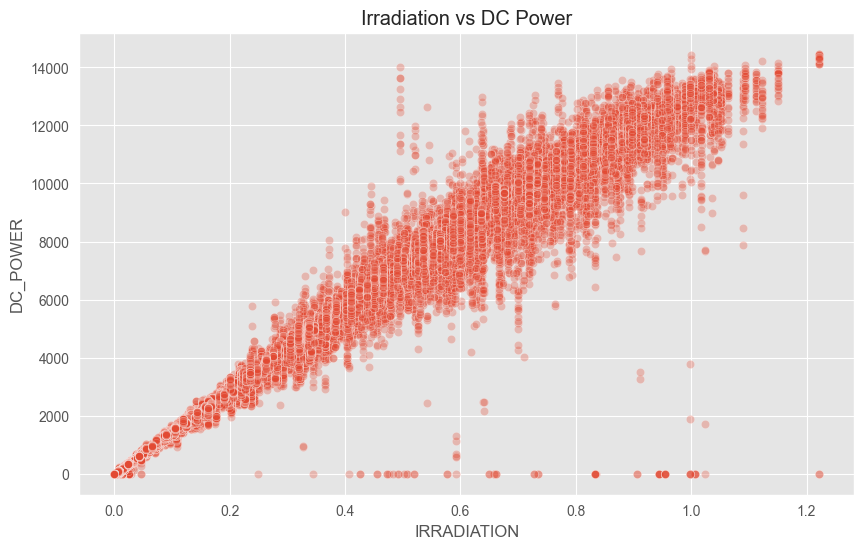

In [4]:
merged_df['HOUR'] = merged_df['DATE_TIME'].dt.hour
merged_df['MONTH'] = merged_df['DATE_TIME'].dt.month

# Visualize relationship between Irradiation and Power
plt.figure(figsize=(10, 6))
sns.scatterplot(x='IRRADIATION', y='DC_POWER', data=merged_df, alpha=0.3)
plt.title('Irradiation vs DC Power')
plt.show()

## 4. Model Selection & Training
We compare three regression models:
1.  **Linear Regression**: Simple baseline.
2.  **Random Forest**: Ensemble method, good for non-linearities.
3.  **XGBoost**: Gradient boosting, excellent for tabular data.

In [5]:
# Features and Target
features = ['IRRADIATION', 'MODULE_TEMPERATURE', 'HOUR', 'MONTH']
target = 'DC_POWER'

X = merged_df[features]
y = merged_df[target]

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
}

results = {}

# Train and Evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {"RMSE": rmse, "R2": r2, "Model": model}
    print(f"{name} -> RMSE: {rmse:.2f}, R2: {r2:.4f}")

Linear Regression -> RMSE: 565.71, R2: 0.9802
Random Forest -> RMSE: 469.24, R2: 0.9864
XGBoost -> RMSE: 469.18, R2: 0.9864


## 5. Evaluation & Conclusion
We select the model with the highest R2 Score and lowest RMSE.

In [6]:
# Find best model
best_model_name = max(results, key=lambda k: results[k]['R2'])
best_model = results[best_model_name]['Model']
best_r2 = results[best_model_name]['R2']

print(f"\n🏆 Best Model: {best_model_name} with R2 Score: {best_r2:.4f}")

# Save the best model
joblib.dump(best_model, 'solar_model.pkl')
print(f"Model saved to 'solar_model.pkl'")


🏆 Best Model: XGBoost with R2 Score: 0.9864
Model saved to 'solar_model.pkl'
